In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from llmcoder.utils import get_data_dir

In [3]:
# Search for analysis results in the data directory
EVAL_CURATED_DIR = get_data_dir('LLMcoder-Eval/eval_curated')
GITHUB_MIX_DIR = get_data_dir('LLMcoder-Eval/github_mix')

In [4]:
# Read the results (json files of the format "results_[config_name}_%Y-%m-%d_%H-%M-%S.json") into a dict
def read_results(results_dir):
    results = {}
    for filename in os.listdir(results_dir):
        if filename.startswith('results_') and filename.endswith('.json'):
            with open(os.path.join(results_dir, filename)) as f:
                results[os.path.splitext(filename)[0]] = json.load(f)
    return results

In [5]:
# Read the analysis results (csv files of the format "results_[config_name}_%Y-%m-%d_%H-%M-%S.csv") into a pandas dataframe
def read_analysis_results(results_dir):
    results = []
    for filename in os.listdir(results_dir):
        if filename.startswith('results_') and filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(results_dir, filename), index_col=0)
            df['config_name'] = filename
            results.append(df)
    return pd.concat(results)

In [6]:
def get_all_results(results_dirs):
    results = {}
    for results_dir in results_dirs:
        results.update(read_results(results_dir))
    return results

def get_all_analysis_results(results_dirs):
    results = []
    for results_dir in results_dirs:
        results.append(read_analysis_results(results_dir))
    return pd.concat(results)

In [7]:
results = {
    'eval_curated': read_results(EVAL_CURATED_DIR),
    'github_mix': read_results(GITHUB_MIX_DIR)
}

analysis_results = {
    'eval_curated': read_analysis_results(EVAL_CURATED_DIR),
    'github_mix': read_analysis_results(GITHUB_MIX_DIR)
}

In [8]:
analysis_results['eval_curated'].head()

,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,config_name
0,405,0.138638,0.494320,0.047904,-7.0,0,543,0,results_plain-w-sys_eval-curated_2023-12-01_15...
1,84,0.060156,0.484596,0.141414,5.0,0,445,0,results_plain-w-sys_eval-curated_2023-12-01_15...
2,2452,0.495438,0.841042,0.017948,1.0,0,2079,0,results_plain-w-sys_eval-curated_2023-12-01_15...
3,386,0.340056,0.834622,0.032541,1.0,0,614,0,results_plain-w-sys_eval-curated_2023-12-01_15...
4,988,0.011361,0.253929,0.000000,9.0,0,680,0,results_plain-w-sys_eval-curated_2023-12-01_15...


In [9]:
analysis_results['eval_curated']['log_levenshtein_distance_score'] = np.log10(analysis_results['eval_curated']['levenshtein_distance_score'] + 1)
analysis_results['github_mix']['log_levenshtein_distance_score'] = np.log10(analysis_results['github_mix']['levenshtein_distance_score'] + 1)

# Remove the regular levenshtein_distance_score
analysis_results['eval_curated'].drop(columns=['levenshtein_distance_score'], inplace=True)
analysis_results['github_mix'].drop(columns=['levenshtein_distance_score'], inplace=True)

In [10]:
# Get the minimum and maximum of each column endind with "_score"
def get_min_max_scores(df):
    return df.filter(regex='_score$').agg(['min', 'max']).transpose()

In [11]:
def scores_histogram(analysis_results):
    min_max_scores = get_min_max_scores(analysis_results)
    min_max_scores

    # Create a histogram of each score for each config
    # The configs are the rows and the scores are the columns

    unique_configs = analysis_results['config_name'].unique()
    unique_scores = [score for score in analysis_results.columns if score.endswith('_score')]
    
    fig, axes = plt.subplots(len(unique_configs), len(unique_scores), figsize=(len(unique_scores) * 3, len(unique_configs) * 2))

    axes = np.array(axes).reshape(len(unique_configs), len(unique_scores))

    for i, score in enumerate(unique_scores):
        for j, config in enumerate(unique_configs):
            config_name_reduced = config.replace('results_', '')
            config_name_reduced = config_name_reduced[:config_name_reduced.find('2023') - 1]

            axes[j, i].hist(analysis_results[analysis_results['config_name'] == config][score], bins=np.linspace(min_max_scores.loc[score, 'min'], min_max_scores.loc[score, 'max'], 20), label=config_name_reduced if i == 0 else None)
            axes[j, i].set_title(f'{score}')

            # Plot the median
            axes[j, i].axvline(analysis_results[analysis_results['config_name'] == config][score].median(), color='tab:red', label='median')

            if i == 0:
                axes[j, i].legend()

    fig.tight_layout()

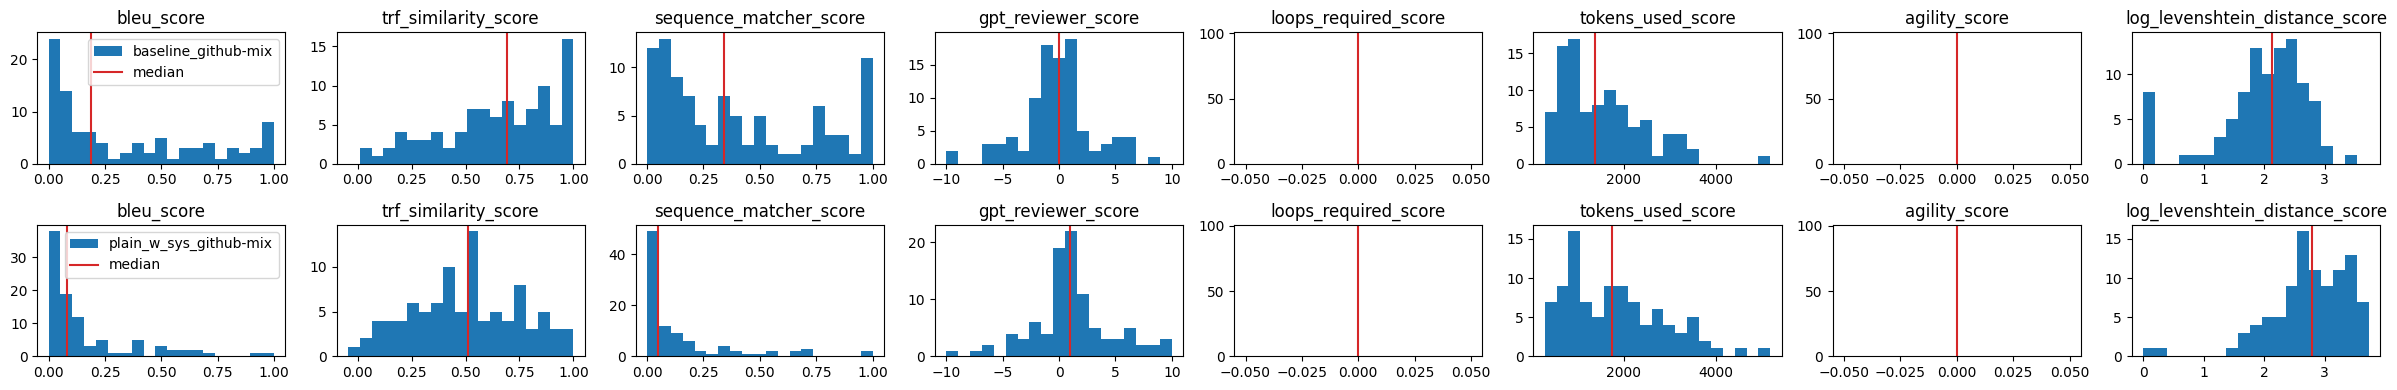

In [12]:
scores_histogram(analysis_results['github_mix'])

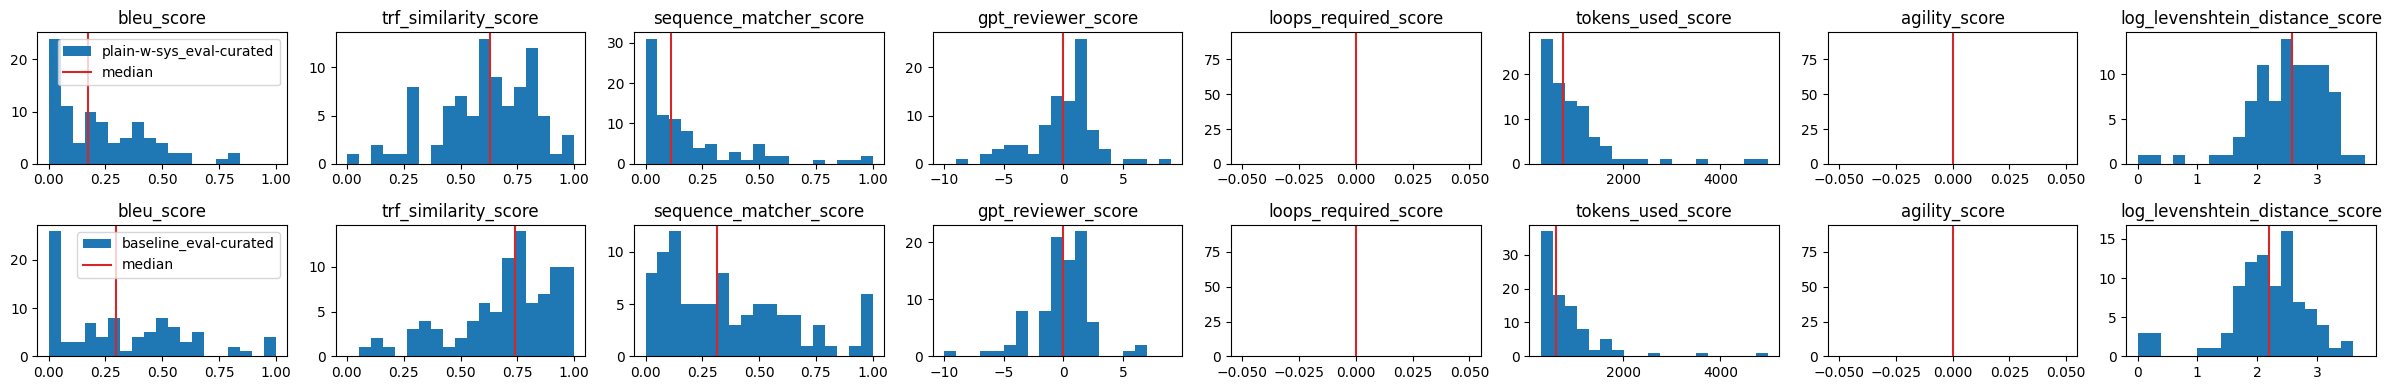

In [13]:
scores_histogram(analysis_results['eval_curated'])